In [1]:
# Imports
%matplotlib notebook
import cvxpy as cp
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver
from sdp_relaxation import (
    build_general_SDP_problem,
    block_diagonal,
    build_cost_matrix,
    build_rotation_constraint_matrices,
    build_measurement_constraint_matrices,
)
import mosek

In [7]:
# make camera
cam = sim.Camera(
    f_u = 160, # focal length in horizonal pixels
    f_v = 160, # focal length in vertical pixels
    c_u = 320, # pinhole projection in horizonal pixels
    c_v = 240, # pinhold projection in vertical pixels
    b = 0.25, # baseline (meters)
    R = 0 * np.eye(4), # covarience matrix for image-space noise
    fov = np.array([[-1,1], [-1, 1], [2, 5]])
)

world = sim.World(
    cam = cam,
    p_wc_extent = np.array([[3], [3], [0]]),
    num_landmarks = 5,
)

<IPython.core.display.Javascript object>


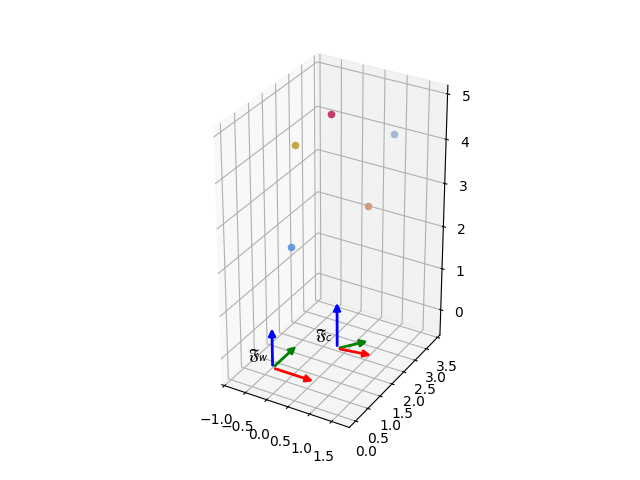

<IPython.core.display.Javascript object>


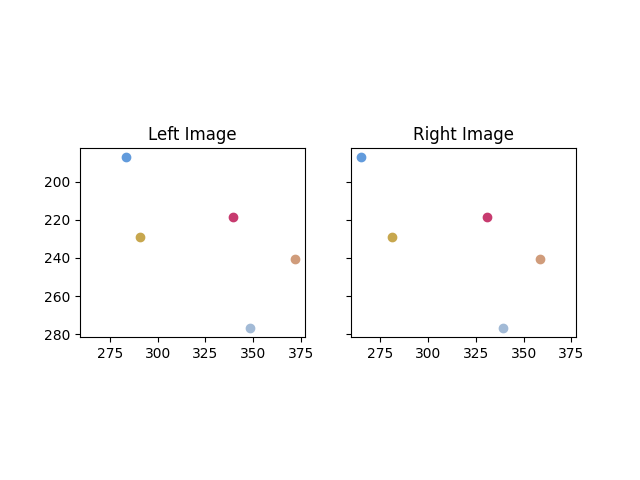

In [10]:
# make random camera pose
"""a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 5
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, cam.fov)"""

world.clear_sim_instance()
world.make_random_sim_instance()
fig, ax, colors = world.render()

# Generative camera model 
y = cam.take_picture(world.T_wc, world.p_w)
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

In [6]:
if False: # tims problem
        # groundtruth pose
        T_cw = np.array([[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 1.2], [0, 0, 0, 1]])  

        # groundtruth landmarks
        J = 5;
        p_w = np.zeros((J,4,1))
        p_w[0,:,:] = np.matrix('1; 1; 2; 1')
        p_w[1,:,:] = np.matrix('1; -1; 2; 1')
        p_w[2,:,:] = np.matrix('-1; 1; 2; 1')
        p_w[3,:,:] = np.matrix('-1; -1; 2; 1')
        p_w[4,:,:] = np.matrix('0; 0; 3; 1')

        a = np.array([[0], [0], [1], [0]])

        # constant camera matrix
        b = 0.2
        f_u = 100
        f_v = 100
        c_u = 50
        c_v = 50

        M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)

        # generate measurements with small amount of noise
        y = np.zeros((J,4,1))
        for j in range(J):
            y[j,:,:] = M @ T_cw @ p_w[j,:,:] / (a.T @ T_cw @ p_w[j,:,:]) #+ 0.01*np.vstack((np.random.randn(3,1), 0))
            # print(y[j,:,:])

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [12]:
T_op = np.eye(4)
#T_op[:3, :3] = np.linalg.inv(T_wc)[:3, :3]
W = np.eye(4)

max_iters = 1000
r0 = np.array([[0], [0], [0]])
gamma_r = 0 #0.01
T_op, local_minima = local_solver.stereo_localization_gauss_newton(
    T_op, y, world.p_w, W, cam.M(), r_0 = r0, gamma_r = gamma_r
)

print("Estimate:\n", T_op)
print("Ground Truth:\n", np.linalg.inv(world.T_wc))

Loss: [[1433.95187173]]
Loss: [[6.06017942]]
Loss: [[3.00384489e-05]]
Loss: [[6.51107957e-16]]
Loss: [[1.77714585e-26]]
Loss: [[5.9776724e-26]]
Estimate:
 [[ 0.95053207 -0.1925799   0.24372479 -0.48270097]
 [ 0.25398213  0.93356696 -0.25287507 -1.36732783]
 [-0.17883475  0.30226761  0.93629719 -0.24363732]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.95053207 -0.1925799   0.24372479 -0.48270097]
 [ 0.25398213  0.93356696 -0.25287507 -1.36732783]
 [-0.17883475  0.30226761  0.93629719 -0.24363732]
 [ 0.          0.          0.          1.        ]]


In [13]:
e_3 = np.zeros((4, 1))
e_3[2] = 1
v = (T_op @ world.p_w) / (e_3.T @ (T_op @ world.p_w))
assert np.isclose((np.eye(4,4) - v @ e_3.T) @ (T_op @ world.p_w), 0).all()

<IPython.core.display.Javascript object>


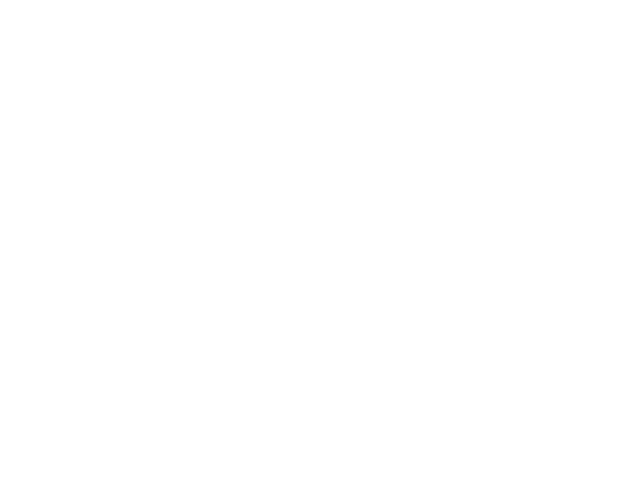

In [14]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation Math

See `math.tex`


## From Stereo Localization to QCQP, and QCQP to SDP

We will define:
$$\mathbf{x} = \begin{bmatrix} \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3 \\ \mathbf{r} \\ \mathbf{u}_1 \\ \dots \\ \mathbf{u}_n \\ \omega\end{bmatrix} \in \mathbb{R}^{13 + 3n}$$

In [15]:
# build x_local from local solution to test matricies

x_1 = T_op[:3, :].T.reshape((12, 1))
x_2 = (T_op @ world.p_w / np.expand_dims((np.array([0, 0, 1, 0]) @ T_op @ world.p_w), -1))[:, [0, 1, 3], :].reshape(-1, 1)
x_local = np.concatenate((x_1, x_2, np.array([[1]])), axis = 0)

### Cost Matrix

In [16]:
# Fow now use the same W for each measurement
Ws = np.zeros((world.num_landmarks, 4, 4))
for i in range(world.num_landmarks):
    Ws[i] = W

# build cost matrix and compare to local solution
n = 13 + 3 * world.num_landmarks
Q = build_cost_matrix(world.num_landmarks, y, Ws, cam.M(), r0, gamma_r)
print(x_local.T @ Q @ x_local, local_minima)

[[-1.40844993e-10]] [[5.9776724e-26]]


### Constraints

In [17]:
As = []
bs = []

# rotation matrix
rot_matrix_As, bs = build_rotation_constraint_matrices()
for rot_matrix_A in rot_matrix_As:
    A = np.zeros((n, n))
    A[:9, :9] = rot_matrix_A
    As.append(A)

# homogenization variable
A = np.zeros((n, n))
A[-1, -1] = 1
As.append(A)
bs.append(1)

# measurments
A_measure, b_measure = build_measurement_constraint_matrices(world.num_landmarks, world.p_w)
As += A_measure
bs += b_measure

for A, b in zip(As, bs):
    print(x_local.T @ A @ x_local, b)
    assert np.isclose(x_local.T @ A @ x_local, b)

[[1.]] 1
[[1.]] 1
[[1.]] 1
[[-1.11022302e-16]] 0
[[5.55111512e-17]] 0
[[5.55111512e-17]] 0
[[1.]] 1
[[-1.11022302e-16]] 0
[[0.]] 0
[[1.]] 1
[[-2.22044605e-16]] 0
[[0.]] 0
[[1.]] 1
[[-2.77555756e-17]] 0
[[2.22044605e-16]] 0
[[1.]] 1
[[0.]] 0
[[-2.22044605e-16]] 0
[[1.]] 1
[[1.11022302e-16]] 0
[[2.22044605e-16]] 0
[[1.]] 1


### Redundant Parrallel Constraint 

Note that $\mathbf{T}\mathbf{p}_k$ and $\mathbf{v}_k$ differ by a constant factor, so we can add
the constraint
\begin{align}
\mathbf{v}_k (\mathbf{T} \mathbf{p}_k)^T = (\mathbf{T} \mathbf{p}_k) \mathbf{v}_k^T \quad \forall k \\
\end{align}



In [18]:
"""
if use_redunant:
    assert False, "This needs to be debugged"
    for k in range(N):
        A = np.zeros((n, n))
        A[0:3, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 0] * e_1 @ e_2.T
        A[3:6, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 1] * e_1 @ e_2.T
        A[6:9, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 2] * e_1 @ e_2.T
        A[9:12, 12 + 3*k: 12+ 3*k+3] = -1 * e_1 @ e_2.T
        A[12 + 3*k: 12+ 3*k+3, 0:3] = p_w[k, 0] * e_1 @ e_2.T
        A[12 + 3*k: 12+ 3*k+3, 3:6] = p_w[k, 1] * e_1 @ e_2.T
        A[12 + 3*k: 12+ 3*k+3, 6:9] = p_w[k, 2] * e_1 @ e_2.T
        A[12 + 3*k: 12+ 3*k+3, 9:12] = e_1 @ e_2.T
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)

        A = np.zeros((n, n))
        A[0:3, -1:] = -p_w[k, 0] * e_1
        A[3:6, -1:] = -p_w[k, 1] * e_1
        A[6:9, -1:] = -p_w[k, 2] * e_1
        A[9:12, -1:] = -1 * e_1
        A[12 + 3*k: 12+ 3*k+3, 0:3] = p_w[k, 0] * e_1 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 3:6] = p_w[k, 1] * e_1 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 6:9] = p_w[k, 2] * e_1 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 9:12] = e_1 @ e_3.T
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)

        A = np.zeros((n, n))
        A[0:3, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 0] * e_1 @ e_3.T
        A[3:6, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 1] * e_1 @ e_3.T
        A[6:9, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 2] * e_1 @ e_3.T
        A[9:12, 12 + 3*k: 12+ 3*k+3] = -1 * e_1 @ e_3.T
        A[-1:, 12 + 3*k: 12+ 3*k+3] = e_1.T
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)

        A = np.zeros((n, n))
        A[0:3, -1:] = -p_w[k, 0] * e_2
        A[3:6, -1:] = -p_w[k, 1] * e_2
        A[6:9, -1:] = -p_w[k, 2] * e_2
        A[9:12, -1:] = -1 * e_2
        A[12 + 3*k: 12+ 3*k+3, 0:3] = p_w[k, 0] * e_2 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 3:6] = p_w[k, 1] * e_2 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 6:9] = p_w[k, 2] * e_2 @ e_3.T
        A[12 + 3*k: 12+ 3*k+3, 9:12] = e_2 @ e_3.T
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)

        A = np.zeros((n, n))
        A[0:3, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 0] * e_2 @ e_3.T
        A[3:6, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 1] * e_2 @ e_3.T
        A[6:9, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 2] * e_2 @ e_3.T
        A[9:12, 12 + 3*k: 12+ 3*k+3] = -1 * e_2 @ e_3.T
        A[-1:, 12 + 3*k: 12+ 3*k+3] = e_2.T
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)

        A = np.zeros((n, n))
        A[0:3, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 0] * e_3 @ e_3.T
        A[3:6, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 1] * e_3 @ e_3.T
        A[6:9, 12 + 3*k: 12+ 3*k+3] = -p_w[k, 2] * e_3 @ e_3.T
        A[9:12, 12 + 3*k: 12+ 3*k+3] = -1 * e_3 @ e_3.T
        A[-1, -1] = 1
        A = 0.5 * (A + A.T)
        As.append(A)
        bs.append(0)
"""
pass

In [19]:
#eps = 1e-8
#mosek_params = {
#    "MSK_DPAR_INTPNT_CO_TOL_DFEAS": eps,
#    "MSK_DPAR_INTPNT_CO_TOL_PFEAS": eps,
#    "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": eps,
#}

prob, X = build_general_SDP_problem(Q, As, bs)
prob.solve(solver=cp.MOSEK, verbose = True)#, mosek_params = mosek_params)

# Print result.
print("The optimal value from the SDP is", prob.value)
print("The optimal value from the local solver is", local_minima)
#print("A solution X is")
X = X.value
print("SDP Solution rank:", np.linalg.matrix_rank(X))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 12 10:12:06 AM: Your problem has 784 variables, 23 constraints, and 0 parameters.
(CVXPY) Oct 12 10:12:06 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 12 10:12:06 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 12 10:12:06 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 12 10:12:06 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 12 10:12:06 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

(CVXPY) Oct 12 10:12:06 AM: Optimal value: 6.647e-05
(CVXPY) Oct 12 10:12:06 AM: Compilation took 2.242e-01 seconds
(CVXPY) Oct 12 10:12:06 AM: Solver (including time spent in interface) took 2.191e-01 seconds
The optimal value from the SDP is 6.646594903128578e-05
The optimal value from the local solver is [[5.9776724e-26]]
SDP Solution rank: 18


<IPython.core.display.Javascript object>


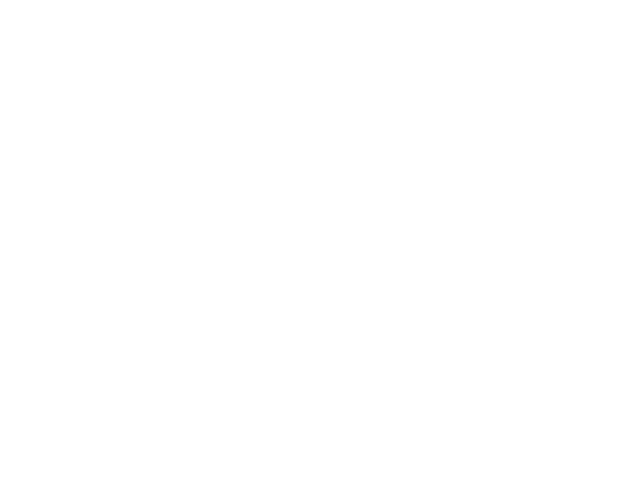

In [20]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
plt.savefig("eigs.png")

/var/folders/_y/_blng15n30s1q2gzf3p3sw2w0000gn/T/ipykernel_82740/1392389762.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))


<IPython.core.display.Javascript object>


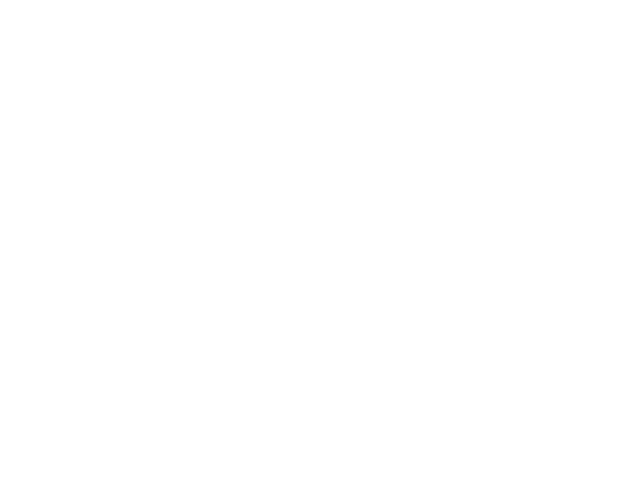

In [21]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))
plt.ylabel("$\log_{10}(\lambda)$")
plt.savefig("eigs.png")

# Certificate

In [22]:
# len(As) = 6 + J*3 + 1

<IPython.core.display.Javascript object>


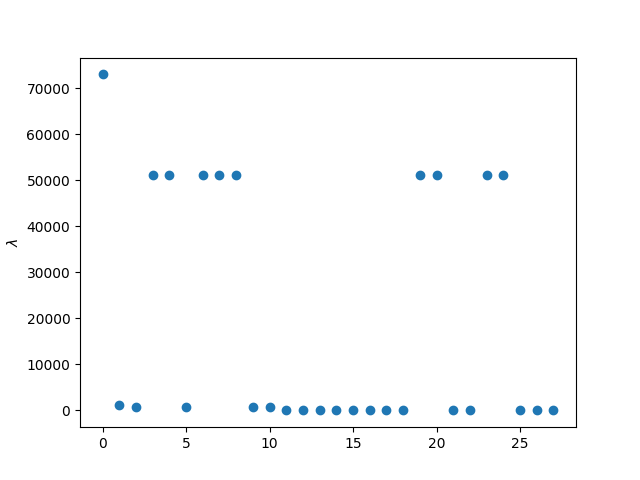

Minimum eigenvalue of H: -2.509281565718683e-11, Maximum eigenvalue of H: 73057.81615595579


In [23]:
lhs = np.concatenate([A @ x_local for A in As], axis = 1) # \in R^((12 + J*5 + 1), (12 + J*3 + 1))
rhs = Q @ x_local
lag_mult = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
lag_mult.shape
H = Q - sum([A * lag_mult[i] for i, A in enumerate(As)])
#np.all(np.linalg.eigvals(H) > 0)
eig_values, _ = np.linalg.eig(H)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
print(f"Minimum eigenvalue of H: {eig_values.min()}, Maximum eigenvalue of H: {eig_values.max()}")

<IPython.core.display.Javascript object>


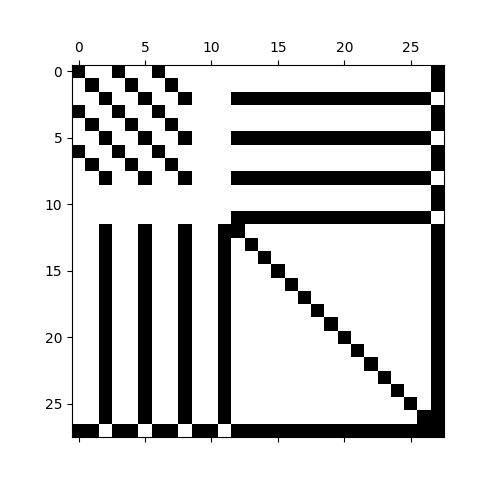

In [24]:
# plot the sparsity of the X matrix (should look dense for rank 1)
Hplt = np.zeros((H.shape[0],H.shape[1],3))
Hplt[abs(H)<1e-50] = [1,1,1]
plt.matshow(Hplt, cmap='Greys')
plt.show()